<a href="https://colab.research.google.com/github/yutao-data/Sepsis_Gene_KnowledgeGraph_Ontology/blob/main/Sepsis_Pathways_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sepsis Pathways

## Libraries Import

In [ ]:
!pip install owlready2
!pip install networkx
!pip install gseapy
!pip install GEOparse

In [ ]:
import requests
from owlready2 import *
from time import sleep
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import networkx as nx
import GEOparse
import gseapy as gp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ontology Import & Definition

In [ ]:
def load_ontology(ontology_path):
    try:
        onto = get_ontology(ontology_path).load()
        return onto
    except Exception as e:
        print(f"Initial attempt failed: {e}")
        print("Retrying...")
        sleep(2)
        try:
            onto = get_ontology(ontology_path).load()
            return onto
        except Exception as e:
            print(f"Retry attempt failed: {e}")
            raise

ontology_path = "/content/drive/MyDrive/stagelisn2024-main/Owl/enriched_ppio_ontology2.owl"
onto = load_ontology(ontology_path)

Initial attempt failed: Cannot download 'http://purl.obolibrary.org/obo/TEMP/'!
Retrying...


In [ ]:
with onto:
    class Gene(Thing):
        pass

    class KeggPathway(Thing):
        pass

    class isPartOfPathway(ObjectProperty):
        domain = [Gene]
        range = [KeggPathway]

## Get KEGG Pathways List

KEGG Pathways is a database and toolset for understanding molecular-level biological information networks, such as metabolism and signal transduction.
https://www.genome.jp/kegg/pathway.html

In [ ]:
def fetch_kegg_pathways():
    base_url = "http://rest.kegg.jp"
    response = requests.get(f"{base_url}/list/pathway/hsa")
    pathways = response.text.strip().split("\n")
    pathway_dict = {}
    for pathway in pathways:
        pathway_id, description = pathway.split("\t")
        pathway_dict[pathway_id] = description
    return pathway_dict

kegg_pathways = fetch_kegg_pathways()
kegg_pathways

{'hsa01100': 'Metabolic pathways - Homo sapiens (human)',
 'hsa01200': 'Carbon metabolism - Homo sapiens (human)',
 'hsa01210': '2-Oxocarboxylic acid metabolism - Homo sapiens (human)',
 'hsa01212': 'Fatty acid metabolism - Homo sapiens (human)',
 'hsa01230': 'Biosynthesis of amino acids - Homo sapiens (human)',
 'hsa01232': 'Nucleotide metabolism - Homo sapiens (human)',
 'hsa01250': 'Biosynthesis of nucleotide sugars - Homo sapiens (human)',
 'hsa01240': 'Biosynthesis of cofactors - Homo sapiens (human)',
 'hsa00010': 'Glycolysis / Gluconeogenesis - Homo sapiens (human)',
 'hsa00020': 'Citrate cycle (TCA cycle) - Homo sapiens (human)',
 'hsa00030': 'Pentose phosphate pathway - Homo sapiens (human)',
 'hsa00040': 'Pentose and glucuronate interconversions - Homo sapiens (human)',
 'hsa00051': 'Fructose and mannose metabolism - Homo sapiens (human)',
 'hsa00052': 'Galactose metabolism - Homo sapiens (human)',
 'hsa00053': 'Ascorbate and aldarate metabolism - Homo sapiens (human)',
 'hsa

## Get Pathways Gene Pairs

In [ ]:
def fetch_kegg_genes_for_pathway(pathway_id):
    """
    Get genes associated with a KEGG pathway.
    Args:
        pathway_id (str): KEGG pathway ID.
    Returns:
        list: List of genes associated with the pathway.
    """
    base_url = "http://rest.kegg.jp"
    response = requests.get(f"{base_url}/link/hsa/{pathway_id}")
    genes = response.text.strip().split("\n")
    gene_list = []
    for gene in genes:
        parts = gene.split("\t")
        if len(parts) > 1 and ":" in parts[1]:
            gene_list.append(parts[1].split(":")[1])
    return gene_list

def find_gene_instance(gene):
    """
    Find a gene instance in the ontology.
    Args:
        gene (str): Gene ID.
    Returns:
        tuple: Gene instance and search patterns.
    """
    search_patterns = [
        f"*Gene_{gene}",
        f"*_{gene}",
        f"*{gene}"
    ]
    for pattern in search_patterns:
        gene_instance = onto.search_one(iri=pattern)
        if gene_instance:
            return gene_instance, search_patterns
    return None, search_patterns

for pathway_id, description in list(kegg_pathways.items()):
    pathway_instance = KeggPathway(f"Pathway_{pathway_id.replace(':', '_')}")
    pathway_instance.label = description
    genes = fetch_kegg_genes_for_pathway(pathway_id)
    print(f"Pathway {pathway_id} associated genes: {genes}")
    for gene in genes:
        if gene == "50":
            print(f"Skipping gene {gene}")
            continue
        gene_instance, search_patterns = find_gene_instance(gene)
        if gene_instance:
            print(f"Associating gene {gene} with pathway {pathway_id}")
            gene_instance.isPartOfPathway = [pathway_instance]
        else:
            gene_instances = list(onto.Gene.instances())

Streaming output truncated to the last 5000 lines.
Associating gene 817 with pathway hsa05152
Associating gene 818 with pathway hsa05152
Associating gene 820 with pathway hsa05152
Associating gene 836 with pathway hsa05152
Associating gene 841 with pathway hsa05152
Associating gene 8411 with pathway hsa05152
Associating gene 842 with pathway hsa05152
Associating gene 843 with pathway hsa05152
Associating gene 8625 with pathway hsa05152
Associating gene 8717 with pathway hsa05152
Associating gene 8767 with pathway hsa05152
Associating gene 8772 with pathway hsa05152
Associating gene 8844 with pathway hsa05152
Associating gene 8877 with pathway hsa05152
Associating gene 8915 with pathway hsa05152
Associating gene 9103 with pathway hsa05152
Associating gene 9114 with pathway hsa05152
Associating gene 929 with pathway hsa05152
Associating gene 972 with pathway hsa05152
Associating gene 9902 with pathway hsa05152
Pathway hsa05100 associated genes: ['10092', '10093', '10094', '10095', '10096

## Onto Check and Visualization

In [ ]:
# Check is there one Gene connect with multiple Pathways
multiple_pathway_genes = []

for gene in onto.Gene.instances():
    if len(set(gene.isPartOfPathway)) > 1:
        multiple_pathway_genes.append(gene.name)

if multiple_pathway_genes:
    print("Gene Connect with Multiple Pathways")
    for gene_name in multiple_pathway_genes:
        print(gene_name)
else:
    print("No Gene Connect with Multiple Pathways")

No Gene Connect with Multiple Pathways


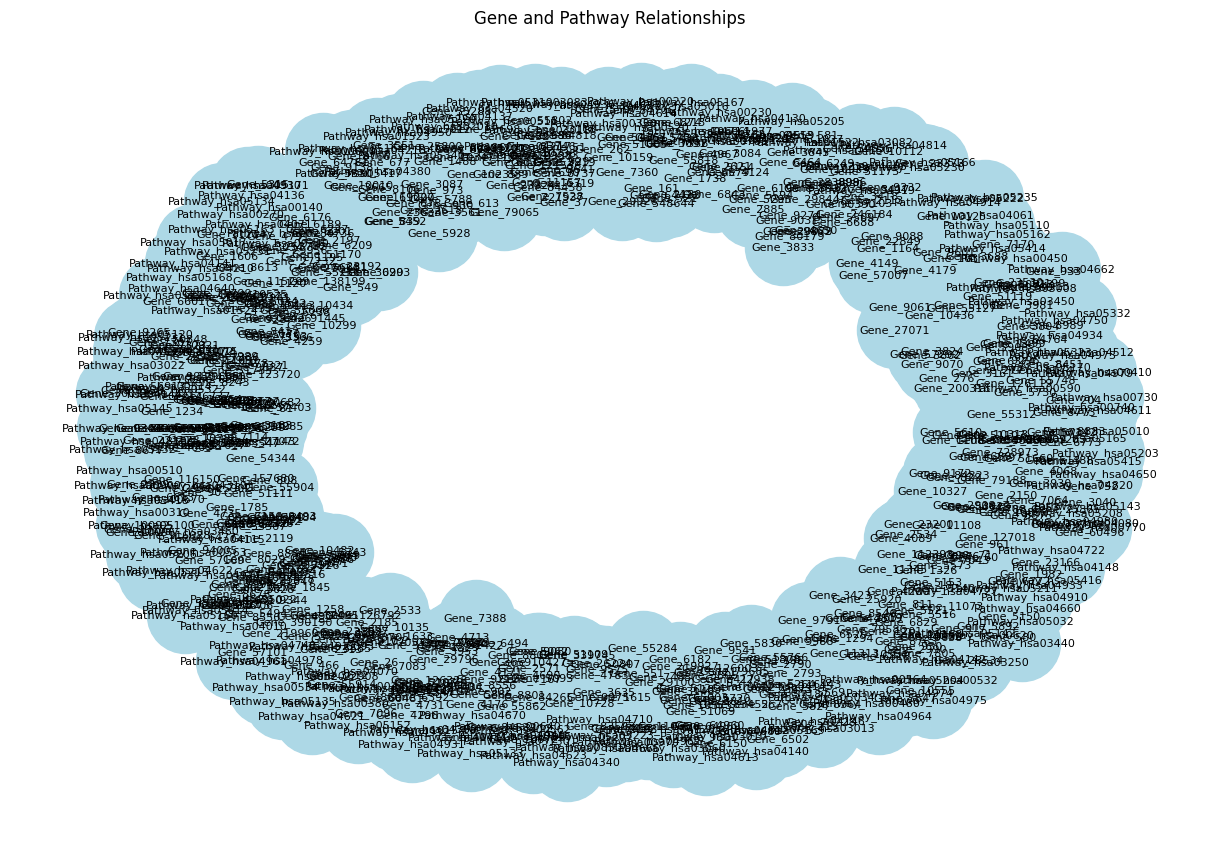

In [ ]:
G = nx.DiGraph()

for gene in onto.Gene.instances():
    gene_name = gene.name
    for pathway in gene.isPartOfPathway:
        pathway_name = pathway.name
        G.add_node(gene_name, label='Gene')
        G.add_node(pathway_name, label='Pathway')
        G.add_edge(gene_name, pathway_name)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, font_color="black")
plt.title('Gene and Pathway Relationships')
plt.show()


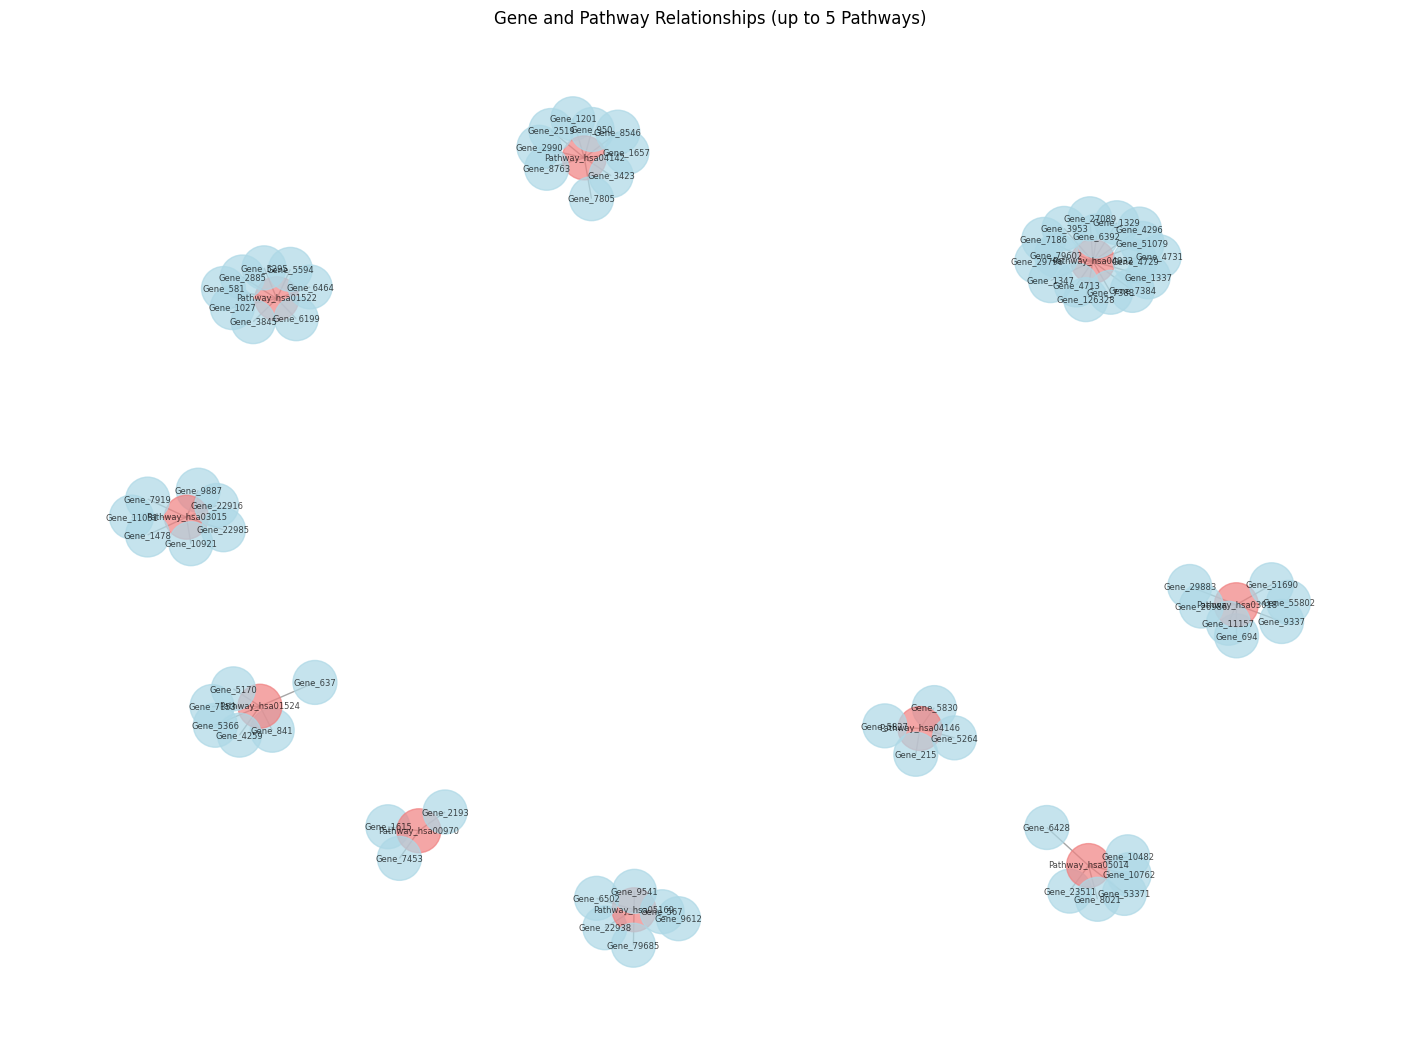

In [ ]:
G = nx.Graph()

pathway_count = 0
max_pathways = 10
selected_pathways = set()

for gene in onto.Gene.instances():
    gene_name = gene.name
    for pathway in gene.isPartOfPathway:
        pathway_name = pathway.name
        if pathway_name not in selected_pathways:
            if pathway_count >= max_pathways:
                break
            selected_pathways.add(pathway_name)
            pathway_count += 1
        if pathway_name in selected_pathways:
            G.add_node(gene_name, label='Gene', color='lightblue')
            G.add_node(pathway_name, label='Pathway', color='lightcoral')
            G.add_edge(gene_name, pathway_name)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)

node_colors = [G.nodes[node]['color'] for node in G.nodes()]

for node in G.nodes:
    if G.degree(node) > 1 and G.nodes[node]['label'] == 'Gene':
        G.nodes[node]['color'] = 'yellow'

nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=6, font_color="black", edge_color='gray', alpha=0.7)
plt.title('Gene and Pathway Relationships (up to 5 Pathways)')
plt.show()

## Save the Updated Ontology

In [ ]:
onto.save(file="/content/drive/MyDrive/stagelisn2024-main/Owl/enriched_ppio_ontology_with_kegg_Pathways.owl")
print("Ontology saved as enriched_ppio_ontology_with_kegg_Pathways.owl")

Ontology saved as enriched_ppio_ontology_with_kegg_Pathways.owl


# GSEA Analysis

Gene Set Enrichment Analysis (GSEA) is a computational method used to determine whether a set of predefined genes shows statistically significant differences in expression under different biological conditions.

In [ ]:
def load_ontology(ontology_path):
    try:
        onto = get_ontology(ontology_path).load()
        return onto
    except Exception as e:
        print(f"Initial attempt failed: {e}")
        print("Retrying...")
        sleep(2)
        try:
            onto = get_ontology(ontology_path).load()
            return onto
        except Exception as e:
            print(f"Retry attempt failed: {e}")
            raise

ontology_path = "/content/drive/MyDrive/stagelisn2024-main/Owl/enriched_ppio_ontology_with_kegg_Pathways.owl"
onto = load_ontology(ontology_path)

Initial attempt failed: Cannot download 'http://purl.obolibrary.org/obo/TEMP/'!
Retrying...


In [ ]:
# Load GEO dataset
gse = GEOparse.get_GEO(filepath="/content/drive/MyDrive/stagelisn2024-main/data/GSE54514_family.soft.gz", silent=True)

expression_data = pd.DataFrame()
for gsm_name, gsm in gse.gsms.items():
    expression_data[gsm_name] = gsm.table.set_index("ID_REF")["VALUE"]

expression_data = expression_data.T
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
expression_data.dropna(axis=1, inplace=True)

expression_data.head()

<ipython-input-5-0cd899760218>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  expression_data[gsm_name] = gsm.table.set_index("ID_REF")["VALUE"]
<ipython-input-5-0cd899760218>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  expression_data[gsm_name] = gsm.table.set_index("ID_REF")["VALUE"]
<ipython-input-5-0cd899760218>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

ID_REF      ILMN_2055271  ILMN_2383229  ILMN_1806310  ILMN_1653355  \
GSM1317896      7.478478      7.732890      7.346000      7.541464   
GSM1317897      7.194329      7.091616      7.127377      7.139050   
GSM1317898      7.118431      7.008995      7.147905      7.251543   
GSM1317899      7.286120      7.122940      7.106208      7.241961   
GSM1317900      7.225378      7.035687      7.268438      7.289307   

ID_REF      ILMN_2359168  ILMN_1735045  ILMN_1680754  ILMN_1755321  \
GSM1317896      7.080655      7.190928      7.043338      7.282018   
GSM1317897      7.076957      7.101918      7.574589      7.151289   
GSM1317898      7.031998      7.064355      7.070183      7.306010   
GSM1317899      7.050389      7.096496      7.110168      7.278481   
GSM1317900      7.099056      7.138676      7.375244      7.279981   

ID_REF      ILMN_1698554  ILMN_1814092  ...  ILMN_1673117  ILMN_1685547  \
GSM1317896      7.467964      7.253072  ...      7.544874      7.085921   
GSM1317897      7.164247      7.159713  ...      7.302628      7.336513   
GSM1317898      7.277900      7.067508  ...      7.048484      7.122465   
GSM1317899      7.289622      7.224060  ...      7.055483      7.104158   
GSM1317900      7.543007      7.231372  ...      7.086588      7.223078   

ID_REF      ILMN_2348512  ILMN_1743643  ILMN_1656676  ILMN_2371169  \
GSM1317896      7.725375      7.403544      9.052076     10.826351   
GSM1317897      7.182846      7.689322     10.352952     11.409938   
GSM1317898      7.274913      7.498920      9.439990     10.910384   
GSM1317899      7.215575      7.570657      9.394814     10.858485   
GSM1317900      7.218124      7.576488      9.480348     11.233749   

ID_REF      ILMN_1701875  ILMN_1786396  ILMN_1653618  ILMN_2137536  
GSM1317896     11.510887      7.748866      7.265069      7.520050  
GSM1317897     12.015053      7.996690      7.173827      7.241760  
GSM1317898     11.717704      8.072896      7.261295      7.426808  
GSM1317899     12.152800      7.796620      7.399535      7.567951  
GSM1317900     12.124186      7.987269      7.235961      7.218149  

[5 rows x 24840 columns]

In [ ]:
gpl_annotations = pd.read_csv("/content/drive/MyDrive/stagelisn2024-main/data/GPL6947-13512.txt", sep="\t", comment='#')
probe_to_gene = gpl_annotations[['ID', 'Symbol']].dropna()
probe_to_gene_dict = dict(zip(probe_to_gene['ID'], probe_to_gene['Symbol']))

In [ ]:
expression_data.rename(columns=probe_to_gene_dict, inplace=True)

expression_data = expression_data.loc[:, expression_data.columns.notnull()]
expression_data = expression_data.loc[:, ~expression_data.columns.duplicated()]

print(expression_data.head())

ID_REF          A1BG      A1CF     A26C3     A2BP1    A4GALT     A4GNT  \
GSM1317896  7.478478  7.732890  7.541464  7.080655  7.190928  7.043338   
GSM1317897  7.194329  7.091616  7.139050  7.076957  7.101918  7.574589   
GSM1317898  7.118431  7.008995  7.251543  7.031998  7.064355  7.070183   
GSM1317899  7.286120  7.122940  7.241961  7.050389  7.096496  7.110168   
GSM1317900  7.225378  7.035687  7.289307  7.099056  7.138676  7.375244   

ID_REF          AAAS      AACS     AACSL   AADACL1  ...     ZUFSP      ZW10  \
GSM1317896  7.282018  7.467964  7.253072  8.000403  ...  7.261229  7.400654   
GSM1317897  7.151289  7.164247  7.159713  7.277861  ...  7.392929  7.539803   
GSM1317898  7.306010  7.277900  7.067508  7.550458  ...  7.558126  7.779663   
GSM1317899  7.278481  7.289622  7.224060  7.449955  ...  7.778482  7.989871   
GSM1317900  7.279981  7.543007  7.231372  7.921234  ...  7.362989  7.685778   

ID_REF        ZWILCH     ZWINT      ZXDB      ZXDC     ZYG11B        ZYX  \
GSM1

In [ ]:
gene_sets = gp.get_library(name='KEGG_2016', organism='Human')

print(f"Number of gene sets: {len(gene_sets)}")
print(f"First few gene set keys: {list(gene_sets.keys())[:5]}")
for key in list(gene_sets.keys())[:2]:
    print(f"Gene set {key}: {gene_sets[key][:5]}")

Number of gene sets: 293
First few gene set keys: ['Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate Homo sapiens hsa00532', 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin Homo sapiens hsa00534', 'Glycosylphosphatidylinositol(GPI)-anchor biosynthesis Homo sapiens hsa00563', 'Steroid biosynthesis Homo sapiens hsa00100', 'SNARE interactions in vesicular transport Homo sapiens hsa04130']
Gene set Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate Homo sapiens hsa00532: ['CSGALNACT2', 'CSGALNACT1', 'CHST7', 'CHPF2', 'CHPF']
Gene set Glycosaminoglycan biosynthesis - heparan sulfate / heparin Homo sapiens hsa00534: ['HS3ST3A1', 'HS3ST1', 'HS3ST3B1', 'XYLT1', 'B3GAT3']


In [ ]:
genes = expression_data.columns.tolist()
expression_values = expression_data.iloc[:, 0].tolist()

print(f"Number of genes: {len(genes)}")
print(f"Number of expression values: {len(expression_values)}")

Number of genes: 19827
Number of expression values: 163


In [ ]:
batch_size = 500
batches = [genes[i:i + batch_size] for i in range(0, len(genes), batch_size)]

all_results = []
for i, batch in enumerate(batches):
    print(f"Processing batch {i+1}/{len(batches)}")
    gsea_results = gp.enrichr(gene_list=batch, gene_sets='KEGG_2016')
    all_results.append(gsea_results.results)

    batch_results_file = f"gsea_results_batch_{i+1}.csv"
    gsea_results.results.to_csv(batch_results_file, index=False)

    time.sleep(1)

combined_results = pd.concat(all_results)

combined_results.to_csv("/content/drive/MyDrive/stagelisn2024-main/data/combined_gsea_results.csv", index=False)

Processing batch 1/40
Processing batch 2/40
Processing batch 3/40
Processing batch 4/40
Processing batch 5/40
Processing batch 6/40
Processing batch 7/40
Processing batch 8/40
Processing batch 9/40
Processing batch 10/40
Processing batch 11/40
Processing batch 12/40
Processing batch 13/40
Processing batch 14/40
Processing batch 15/40
Processing batch 16/40
Processing batch 17/40
Processing batch 18/40
Processing batch 19/40
Processing batch 20/40
Processing batch 21/40
Processing batch 22/40
Processing batch 23/40
Processing batch 24/40
Processing batch 25/40
Processing batch 26/40
Processing batch 27/40
Processing batch 28/40
Processing batch 29/40
Processing batch 30/40
Processing batch 31/40
Processing batch 32/40
Processing batch 33/40
Processing batch 34/40
Processing batch 35/40
Processing batch 36/40
Processing batch 37/40
Processing batch 38/40
Processing batch 39/40
Processing batch 40/40


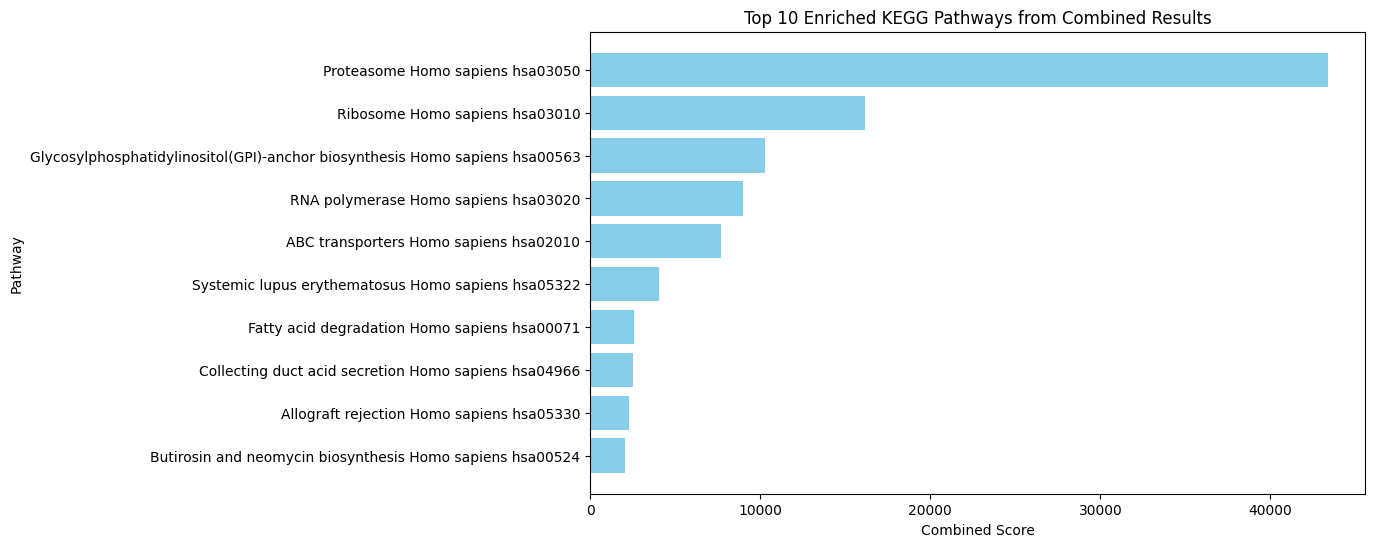

In [ ]:
def plot_gsea_barplot(results, title):
    results_df = results[results['Adjusted P-value'] < 0.05]
    results_df = results_df.sort_values('Combined Score', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(results_df['Term'], results_df['Combined Score'], color='skyblue')
    plt.xlabel('Combined Score')
    plt.ylabel('Pathway')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_gsea_barplot(combined_results, 'Top 10 Enriched KEGG Pathways from Combined Results')

In [ ]:
top10_results = []
top10_results = combined_results.sort_values('Adjusted P-value').head(10)
print("Top 10 Enriched Pathways:")
for idx, row in top10_results.iterrows():
    print(f"Pathway: {row['Term']}, Description: {row['Overlap']}, Adjusted P-value: {row['Adjusted P-value']}, Combined Score: {row['Combined Score']}")

Top 10 Enriched Pathways:
Pathway: Ribosome Homo sapiens hsa03010, Description: 83/137, Adjusted P-value: 1.9094607153954007e-96, Combined Score: 16139.60892932844
Pathway: Proteasome Homo sapiens hsa03050, Description: 39/44, Adjusted P-value: 1.2467647559451807e-55, Combined Score: 43400.03007756811
Pathway: Systemic lupus erythematosus Homo sapiens hsa05322, Description: 57/135, Adjusted P-value: 2.465123053060073e-53, Combined Score: 4035.90770700008
Pathway: Olfactory transduction Homo sapiens hsa04740, Description: 75/415, Adjusted P-value: 1.717309207605054e-40, Combined Score: 960.3196664670832
Pathway: Metabolic pathways Homo sapiens hsa01100, Description: 122/1239, Adjusted P-value: 1.585860696872234e-38, Combined Score: 490.5866384929087
Pathway: ABC transporters Homo sapiens hsa02010, Description: 30/44, Adjusted P-value: 3.1028346209092604e-36, Combined Score: 7675.109852309055
Pathway: Jak-STAT signaling pathway Homo sapiens hsa04630, Description: 47/158, Adjusted P-value

# Network topology analysis

Spearman Network Topology Analysis is a method to study the relationships between genes by constructing networks based on Spearman correlation, and analyzing the network's structural properties and interactions.

In [ ]:
probe_to_gene = gpl_annotations[['ID', 'Symbol']].dropna()
probe_to_gene.set_index('ID', inplace=True)
probe_to_gene_dict = probe_to_gene['Symbol'].to_dict()

expression_data.columns = [probe_to_gene_dict.get(probe, probe) for probe in expression_data.columns]

expression_data = expression_data.loc[:, ~expression_data.columns.duplicated(keep='first')]
expression_data = expression_data.loc[:, expression_data.columns != 'nan']

expression_data

A1BG      A1CF     A26C3     A2BP1    A4GALT     A4GNT  \
GSM1317896  7.478478  7.732890  7.541464  7.080655  7.190928  7.043338   
GSM1317897  7.194329  7.091616  7.139050  7.076957  7.101918  7.574589   
GSM1317898  7.118431  7.008995  7.251543  7.031998  7.064355  7.070183   
GSM1317899  7.286120  7.122940  7.241961  7.050389  7.096496  7.110168   
GSM1317900  7.225378  7.035687  7.289307  7.099056  7.138676  7.375244   
...              ...       ...       ...       ...       ...       ...   
GSM1318054  7.295936  7.060583  7.392929  7.043281  6.967715  7.024879   
GSM1318055  7.041956  7.164970  7.249058  7.101085  7.011040  7.013042   
GSM1318056  7.263118  7.054762  7.502470  7.047527  7.149610  7.163641   
GSM1318057  7.272597  7.076231  7.226006  7.003315  7.052817  7.086477   
GSM1318058  7.184081  7.059470  7.291964  7.128857  7.032658  7.297711   

                AAAS      AACS     AACSL   AADACL1  ...     ZUFSP      ZW10  \
GSM1317896  7.282018  7.467964  7.253072  8.000403  ...  7.261229  7.400654   
GSM1317897  7.151289  7.164247  7.159713  7.277861  ...  7.392929  7.539803   
GSM1317898  7.306010  7.277900  7.067508  7.550458  ...  7.558126  7.779663   
GSM1317899  7.278481  7.289622  7.224060  7.449955  ...  7.778482  7.989871   
GSM1317900  7.279981  7.543007  7.231372  7.921234  ...  7.362989  7.685778   
...              ...       ...       ...       ...  ...       ...       ...   
GSM1318054  7.204382  7.407452  7.204021  7.640658  ...  7.183167  7.818964   
GSM1318055  7.200201  7.361231  7.237278  7.626405  ...  7.546176  7.560909   
GSM1318056  7.299003  7.177127  7.358461  7.690511  ...  7.423051  7.916970   
GSM1318057  7.265855  7.351982  7.099441  7.596143  ...  7.247600  7.867128   
GSM1318058  7.300416  7.250732  7.130372  7.685326  ...  7.133750  7.712188   

              ZWILCH     ZWINT      ZXDB      ZXDC     ZYG11B        ZYX  \
GSM1317896  7.496609  7.016264  7.085921  7.725375   9.052076  10.826351   
GSM1317897  7.407295  7.105931  7.336513  7.182846  10.352952  11.409938   
GSM1317898  7.427119  7.088877  7.122465  7.274913   9.439990  10.910384   
GSM1317899  7.323535  7.032182  7.104158  7.215575   9.394814  10.858485   
GSM1317900  7.096006  7.190862  7.223078  7.218124   9.480348  11.233749   
...              ...       ...       ...       ...        ...        ...   
GSM1318054  7.375044  7.084133  7.216369  7.374018   9.721060   9.285913   
GSM1318055  7.352809  7.128333  7.131184  7.153944   9.452502   9.146516   
GSM1318056  7.459101  7.003916  7.263552  7.182785   9.323565   9.822584   
GSM1318057  7.342611  6.993684  7.312894  7.275300   9.462346   9.989327   
GSM1318058  7.179785  6.997850  7.187146  7.392605   9.740227  10.641799   

               ZZEF1      ZZZ3  
GSM1317896  7.748866  7.265069  
GSM1317897  7.996690  7.173827  
GSM1317898  8.072896  7.261295  
GSM1317899  7.796620  7.399535  
GSM1317900  7.987269  7.235961  
...              ...       ...  
GSM1318054  8.038133  7.669674  
GSM1318055  7.870416  7.515363  
GSM1318056  7.919065  7.487621  
GSM1318057  8.089670  7.624039  
GSM1318058  8.226776  7.123522  

[163 rows x 19827 columns]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


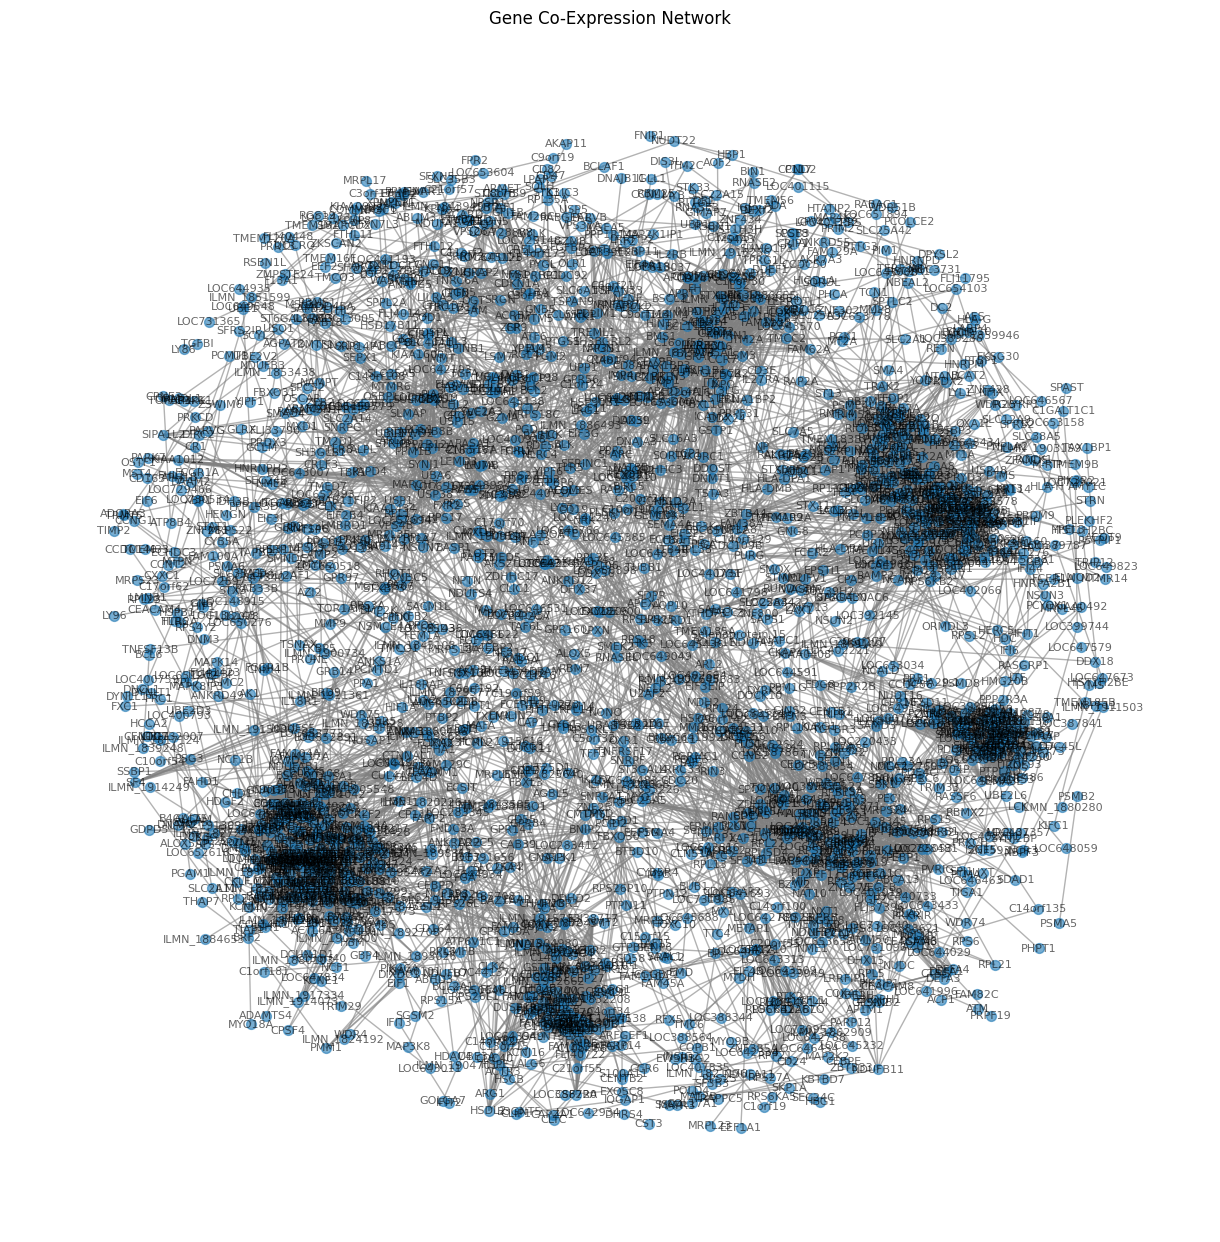

Average Clustering Coefficient: 0.45299488030823093
Density: 0.007395719166450954
Modularity: 0.8083465887610923
Average Path Length of Largest Connected Component: 7.931592314618808
Top 10 Hub Genes by Degree Centrality:
Gene: ILMN_1850501, Degree Centrality: 0.061332055582175374
Gene: ACPT, Degree Centrality: 0.06085289889793963
Gene: ILMN_1913476, Degree Centrality: 0.059894585529468136
Gene: FCGR3A, Degree Centrality: 0.05797795879252516
Gene: ILMN_1915345, Degree Centrality: 0.057498802108289414
Gene: ILMN_1817609, Degree Centrality: 0.056061332055582176
Gene: DSCAM, Degree Centrality: 0.05558217537134643
Gene: FZD7, Degree Centrality: 0.05558217537134643
Gene: LOC654155, Degree Centrality: 0.05174892189746047
Gene: BDKRB1, Degree Centrality: 0.05079060852898898


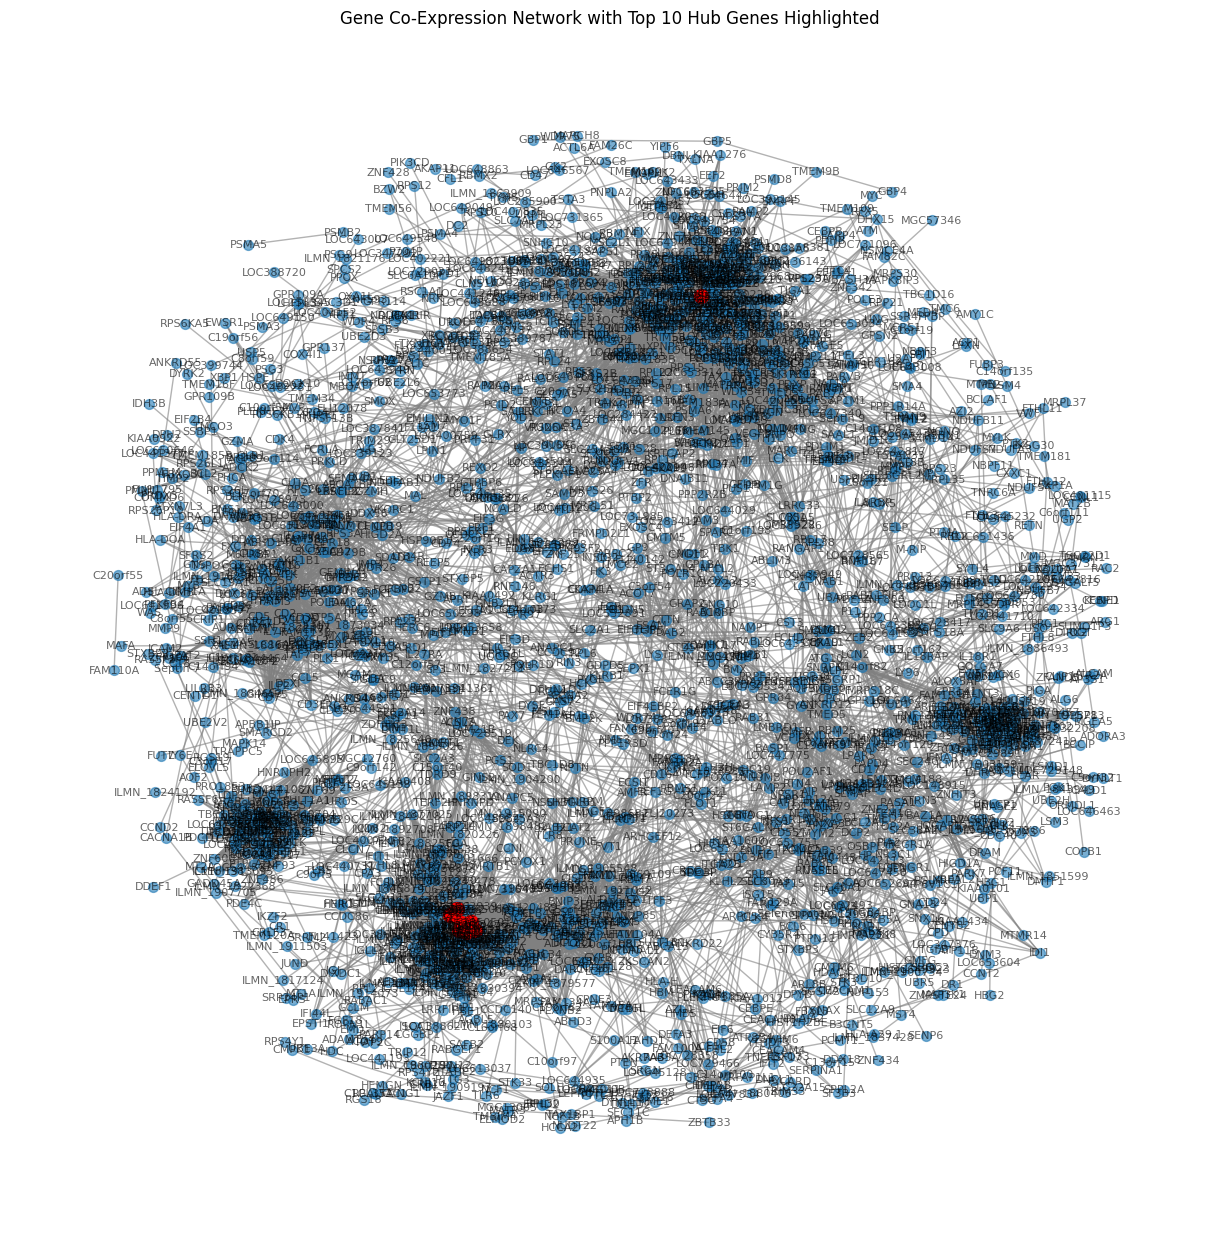

In [ ]:
threshold = 0.8

gene_names = expression_data.columns
n_genes = len(gene_names)
sparse_matrix = csr_matrix((n_genes, n_genes), dtype=np.float32)

chunk_size = 10000
for start in range(0, n_genes, chunk_size):
    end = min(start + chunk_size, n_genes)
    chunk = expression_data.iloc[:, start:end]
    correlation_chunk = chunk.corr(method='spearman')
    mask = (correlation_chunk.abs() > threshold) & (correlation_chunk != 1)
    significant_chunk = correlation_chunk[mask]

    for col in significant_chunk.columns:
        for idx in significant_chunk.index:
            if not pd.isnull(significant_chunk.loc[idx, col]):
                sparse_matrix[gene_names.get_loc(idx), gene_names.get_loc(col)] = significant_chunk.loc[idx, col]

G = nx.Graph()

rows, cols = sparse_matrix.nonzero()
for row, col in zip(rows, cols):
    G.add_edge(gene_names[row], gene_names[col], weight=sparse_matrix[row, col])

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, edge_color='grey', alpha=0.6)
plt.title("Gene Co-Expression Network")
plt.show()

nx.write_graphml(G, "gene_co_expression_network.graphml")

clustering_coefficient = nx.average_clustering(G)
density = nx.density(G)
largest_component = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_component)
modularity = nx.community.modularity(G, [list(c) for c in nx.community.greedy_modularity_communities(G)])
average_path_length = nx.average_shortest_path_length(subgraph)

print(f"Average Clustering Coefficient: {clustering_coefficient}")
print(f"Density: {density}")
print(f"Modularity: {modularity}")
print(f"Average Path Length of Largest Connected Component: {average_path_length}")

degree_centrality = nx.degree_centrality(G)
hub_genes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Hub Genes by Degree Centrality:")
for gene, centrality in hub_genes:
    print(f"Gene: {gene}, Degree Centrality: {centrality}")

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, edge_color='grey', alpha=0.6)
nx.draw_networkx_nodes(G, pos, nodelist=[gene for gene, centrality in hub_genes], node_color='r', node_size=100)
plt.title("Gene Co-Expression Network with Top 10 Hub Genes Highlighted")
plt.show()

# Visualization

# Future Works

1. Implement on more datasets
Current only implement on Dataset GSE54514, but more Dataset about Sepsis like GSE57065, GSE64456

2. Add the comparition between Survivors / Non-Survivors / Heathy

3. Get more domain knowledge in Gene

4. T cell receptor signaling (TCR) pathway and antigen processing?